# Inference for Numerical Data
Copied and adapted from OpenStats Intro ["Inference for numerical data" lab](http://htmlpreview.github.io/?https://github.com/andrewpbray/oiLabs-base-R/blob/master/inf_for_numerical_data/inf_for_numerical_data.html), a product of OpenIntro that is released under a [Creative Commons Attribution-ShareAlike 3.0 Unported](http://creativecommons.org/licenses/by-sa/3.0). Original lab was adapted for OpenIntro by Mine Çetinkaya-Rundel from a lab written by the faculty and TAs of UCLA Statistics.

## North Carolina births

In 2004, the state of North Carolina released a large data set containing information on births recorded in this state. This data set is useful to researchers studying the relation between habits and practices of expectant mothers and the birth of their children. We will work with a random sample of observations from this data set.

The [data set](https://www.openintro.org/stat/data/?data=nc) contains 1000 randomly selected births from the birth records released by the state of North Carolina in 2004. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import numpy as np
import statsmodels.stats.weightstats
# from __future__ import print_function # Python 2 users, uncomment this statement

## Exploratory analysis

Load the nc data set into the notebook.

In [2]:
# load data into dataframe
ncbirths = pd.read_csv("https://www.openintro.org/stat/data/nc.csv")

We have observations on 13 different variables, some categorical and some numerical. The meaning of each variable is as follows.

|variable |	description |
|---------|-------------|
|fage	|father’s age in years.|
|mage	|mother’s age in years.|
|mature	|maturity status of mother.|
|weeks	|length of pregnancy in weeks.|
|premie	|whether the birth was classified as premature (premie) or full-term.|
|visits	|number of hospital visits during pregnancy.|
|marital|	whether mother is married or not married at birth.|
|gained	|weight gained by mother during pregnancy in pounds.|
|weight	|weight of the baby at birth in pounds.|
|lowbirthweight	|whether baby was classified as low birthweight (low) or not (not low).|
|gender	|gender of the baby, female or male.|
|habit	|status of the mother as a nonsmoker or a smoker.|
|whitemom|	whether mom is white or not white.|

As a first step in the analysis, we should consider summaries of the data. This can be done using the `describe` command:

In [3]:
ncbirths.describe()

/home/michael/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,fage,mage,weeks,visits,gained,weight
count,829.000000,1000.000000,998.000000,991.000000,973.000000,1000.00000
mean,30.255730,27.000000,38.334669,12.104945,30.325797,7.10100
std,6.763766,6.213583,2.931553,3.954934,14.241297,1.50886
min,14.000000,13.000000,20.000000,0.000000,0.000000,1.00000
25%,NaN,22.000000,NaN,NaN,NaN,6.38000
50%,NaN,27.000000,NaN,NaN,NaN,7.31000
75%,NaN,32.000000,NaN,NaN,NaN,8.06000
max,55.000000,50.000000,45.000000,30.000000,85.000000,11.75000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
fage              829 non-null float64
mage              1000 non-null int64
mature            1000 non-null object
weeks             998 non-null float64
premie            998 non-null object
visits            991 non-null float64
marital           999 non-null object
gained            973 non-null float64
weight            1000 non-null float64
lowbirthweight    1000 non-null object
gender            1000 non-null object
habit             999 non-null object
whitemom          998 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 101.6+ KB


### Exercise 1 - Exploratory
1. What are the cases in this data set? How many cases are there in our sample?
2. Which variables are numerical and which ones are categorical?
3. For numerical values, are their outliers? If you aren't sure or want to take a closer look at the data, make a graph.

_One case is one birth?_

In [18]:
"Numeric columns:", list(ncbirths._get_numeric_data().columns)

('Numeric columns:', ['fage', 'mage', 'weeks', 'visits', 'gained', 'weight'])

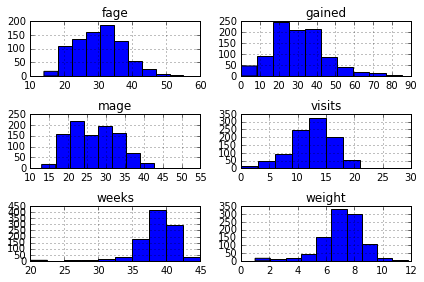

In [13]:
ncbirths.hist()
plt.tight_layout()

Consider the possible relationship between a mother’s smoking habit and the weight of her baby. Plotting the data is a useful first step because it helps us quickly visualize trends, identify strong associations, and develop research questions.

### Exercise 2
Make a side-by-side box plot of `habit` and `weight`. What does the plot highlight about the relationship between these two variables?

In [55]:
nonsmoking = ncbirths.weight[ncbirths.habit=='nonsmoker']
smoking =    ncbirths.weight[ncbirths.habit=='smoker']

{'boxes': [<matplotlib.lines.Line2D at 0x7f6288962f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f628896ea20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6288973ba8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6288973390>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f62889689b0>,
  <matplotlib.lines.Line2D at 0x7f6288981b38>]}

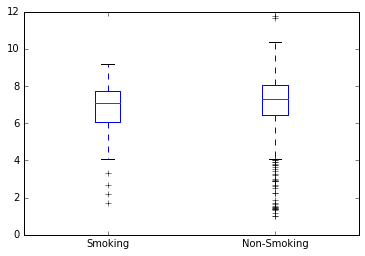

In [56]:
plt.figure()
plt.boxplot([smoking, nonsmoking], labels=['Smoking', 'Non-Smoking'])

In [58]:
len(smoking), len(nonsmoking)

(126, 873)

The box plots show how the medians of the two distributions compare, but we can also compare the means of the distributions using the following function to split the `weight` variable into the `habit` groups, then take the mean of each using the `mean` function.

In [64]:
smoke_or_not = ncbirths.groupby("habit")

In [73]:
smoke_or_not.weight.mean()

habit
nonsmoker    7.144273
smoker       6.828730
Name: weight, dtype: float64

In [131]:
smoke_or_not.agg(np.mean).weight

habit
nonsmoker    7.144273
smoker       6.828730
Name: weight, dtype: float64

There is an observed difference, but is this difference statistically significant? In order to answer this question we will conduct a hypothesis test.

## Inference
### Exercise 3
Check if the conditions necessary for inference are satisfied. Note that you will need to obtain sample sizes to check the conditions. You can compute the group size using the same by command above but replacing `mean` with `len`.

In [129]:
smoke_or_not.agg(len).weight

habit
nonsmoker    873.0
smoker       126.0
Name: weight, dtype: float64

In [126]:
nonsmoking.sample(10).mean(), nonsmoking.mean()

(7.021000000000001, 7.144272623138631)

In [132]:
smoking.sample(10).mean(), smoking.mean()

(7.093999999999999, 6.828730158730158)

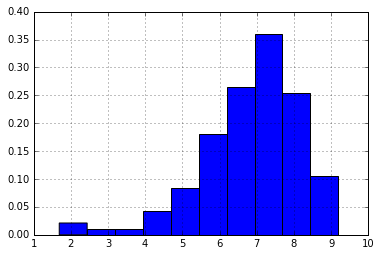

In [144]:
smoking.hist(normed=True)

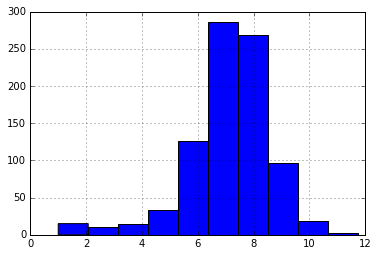

In [136]:
nonsmoking.hist()

### Exercise 4
Write the hypotheses for testing if the average weights of babies born to smoking and non-smoking mothers are different. Calculate the Z-score and p-value for the hypothesis test.

_**Null Hypothesis**: The mean weight of a baby born from a mother who smokes is the same mean weight as from a mother who does not smoke._

_**Altnerative Hypothesis**: The means are different_

In [76]:
# functions to visualize z-test
def _gauss(x, mu=0, sigma=1):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*pow((x-mu)/sigma,2))
gauss = np.vectorize(_gauss)

def plot_twosided_ztest(se):
    fig = plt.figure()
    g = fig.add_subplot(111)
    dx = np.linspace(-3.5*se, 3.5*se)
    g.plot(dx, gauss(dx, sigma=se))
    zx = np.linspace(htest[0]*se, max(dx))
    g.fill_between(zx, 0, gauss(zx, sigma=se))
    g.fill_between(-zx, 0, gauss(-zx, sigma=se))
    g.yaxis.set_visible(False)

lTest statistics: Z = 2.35901
p-value = 0.0183237


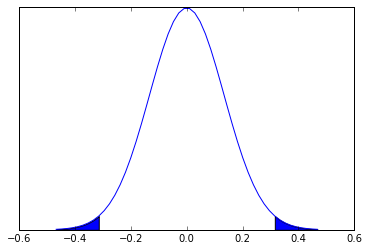

In [77]:
# hypthesis test from exercise 4
group1 = ncbirths[ncbirths["habit"]=="nonsmoker"].weight
group2 = ncbirths[ncbirths["habit"]=="smoker"].weight
d1 = statsmodels.stats.weightstats.DescrStatsW(group1)
d2 = statsmodels.stats.weightstats.DescrStatsW(group2)
cm = statsmodels.stats.weightstats.CompareMeans(d1, d2)
htest = cm.ztest_ind(usevar="unequal")
print("lTest statistics: Z = {:n}".format(htest[0]))
print("p-value = {:n}".format(htest[1]))
plot_twosided_ztest(cm.std_meandiff_separatevar)

### Exercise 5
Calculate the 95% confidence interval for the difference in means $\mu_{nonsmoker} - \mu_{smoker}$. Read the documentation for statsmodels.stats.weightstats.CompareMeans (current instance is `cm`) for help.

In [99]:
smoking_stats    = statsmodels.stats.weightstats.DescrStatsW(smoking)
nonsmoking_stats = statsmodels.stats.weightstats.DescrStatsW(nonsmoking)

In [88]:
mean_comp = statsmodels.stats.weightstats.CompareMeans(smoking_stats, nonsmoking_stats)

In [96]:
mean_comp.tconfint_diff()

(-0.59656479916251759, -0.034520129654364906)

In [105]:
smoking_stats.mean, nonsmoking_stats.mean

(6.828730158730159, 7.1442726231386002)

### Exercise 6
See DescrStatsW [documentation](http://statsmodels.sourceforge.net/devel/generated/statsmodels.stats.weightstats.DescrStatsW.html) for useful methods.

1. Calculate a 95% confidence interval for the average length of pregnancies (weeks) and interpret it in context. Note that since you’re doing inference on a single population parameter, there is no explanatory variable, so you can omit the x variable from the function.

2. Calculate a new confidence interval for the same parameter at the 90% confidence level. You can change the confidence level by adding a new argument to the function: conflevel = 0.90.

3. Conduct a hypothesis test evaluating whether the average weight gained by younger mothers is different than the average weight gained by mature mothers.

4. Now, a non-inference task: Determine the age cutoff for younger and mature mothers. Use a method of your choice, and explain how your method works.

5. Pick a pair of numerical and categorical variables and come up with a research question evaluating the relationship between these variables. Formulate the question in a way that it can be answered using a hypothesis test and/or a confidence interval. Answer your question using the inference function, report the statistical results, and also provide an explanation in plain language.

In [114]:
weeks_stats = statsmodels.stats.weightstats.DescrStatsW(list(ncbirths.weeks))

In [1]:
ncbirths.weeks.plot(kind='box', vert=False), ncbirths.weeks.mean()

NameError: name 'ncbirths' is not defined

In [2]:
1, 2

(1, 2)

In [152]:
smoking.skew(),nonsmoking.skew()

(-1.0138359043095422, -1.186873486573975)

In [149]:
np.array([1,2,3]) * 2

array([2, 4, 6])

# Inference for categorical data

Copied and adapted from OpenStats Intro "Inference for categorical data" lab, a product of OpenIntro that is released under a [Creative Commons Attribution-ShareAlike 3.0 Unported](http://creativecommons.org/licenses/by-sa/3.0). Original lab was written for OpenIntro by Andrew Bray and Mine Çetinkaya-Rundel.

In August of 2012, news outlets ranging from the [Washington Post](http://www.washingtonpost.com/national/on-faith/poll-shows-atheism-on-the-rise-in-the-us/2012/08/13/90020fd6-e57d-11e1-9739-eef99c5fb285_story.html) to the [Huffington Post](http://www.huffingtonpost.com/2012/08/14/atheism-rise-religiosity-decline-in-america_n_1777031.html) ran a story about the rise of atheism in America. The source for the story was a poll that asked people, “Irrespective of whether you attend a place of worship or not, would you say you are a religious person, not a religious person or a convinced atheist?” This type of question, which asks people to classify themselves in one way or another, is common in polling and generates categorical data. In this lab we take a look at the atheism survey and explore what’s at play when making inference about population proportions using categorical data.

The data set is available here: https://www.openintro.org/stat/data/?data=atheism. The one that accompanies this notebook has had the comma removed from "Korea, Reb (South)".


### Note: Exercises 4-10 are most important for our purposes.


## The survey

To access the press release for the poll, conducted by WIN-Gallup International, click on the following link:

http://www.wingia.com/web/files/richeditor/filemanager/Global_INDEX_of_Religiosity_and_Atheism_PR__6.pdf

Take a moment to review the report then address the following questions.

### Exercise 1
In the first paragraph, several key findings are reported. Do these percentages appear to be *sample* statistics (derived from the data sample) or *population parameters*?

### Exercise 2

The title of the report is “Global Index of Religiosity and Atheism”. To generalize the report’s findings to the global human population, what must we assume about the sampling method? Does that seem like a reasonable assumption?

## The data

Turn your attention to Table 6 (pages 15 and 16), which reports the sample size and response percentages for all 57 countries. While this is a useful format to summarize the data, we will base our analysis on the original data set of individual responses to the survey. Load this data set into R with the following command.

In [ ]:
atheism = pd.read_csv("atheism.csv")

### Exercise 3
What does each row of Table 6 correspond to? What does each row of `atheism` correspond to?

To investigate the link between these two ways of organizing this data, take a look at the estimated proportion of atheists in the United States. Towards the bottom of Table 6, we see that this is 5%. We should be able to come to the same number using the `atheism`
data.

### Exercise 4
Using the command below, create a new dataframe called `us12` that contains only the rows in `atheism` associated with respondents to the 2012 survey from the United States. Next, calculate the proportion of atheist responses. Does it agree with the percentage in Table 6? If not, why?

In [ ]:
us12 = atheism[ (atheism["nationality"] == "United States") & (atheism["year"] == 2012)]

## Inference on proportions

As was hinted at in Exercise 1, Table 6 provides *statistics*, that is, calculations made from the sample of 51,927 people. What we’d like, though, is insight into the population *parameters*. You answer the question, “What proportion of people in your sample reported being atheists?” with a statistic; while the question “What proportion of people on earth would report being atheists” is answered with an estimate of the parameter.

The inferential tools for estimating population proportion are analogous to those used for means in the last chapter: the confidence interval and the hypothesis test.

### Exercise 5
Write out the conditions for inference to construct a 95% confidence interval for the proportion of atheists in the United States in 2012. Are you confident all conditions are met?

If the conditions for inference are reasonable, we can calculate the standard error and construct the confidence interval. The output of the following cell is the 95% confidence interval. More on how it is calculated follows below.

In [ ]:
def atheist_confidence_interval(data, conf_levl=0.95):
    """ data (pandas.DataFrame) -- subset of atheism data
        conf_levl (float) -- confidence level 
    """
    zstar = norm.ppf((1-(1-conf_levl)/2))
    probs = data.response.value_counts(normalize=True)
    se = np.sqrt(probs.prod()/len(us12.index))
    ci = np.array([-1,1]) * zstar * se + probs["atheist"]
    print("{:.0%} confidence interval: ({:.4f}, {:.4f})".format(conf_levl, *ci))
    return 

In [ ]:
atheist_confidence_interval(us12)

Although formal confidence intervals and hypothesis tests don’t show up in the report, suggestions of inference appear at the bottom of page 7: “In general, the error margin for surveys of this kind is $\pm$ 3-5% at 95% confidence”.

### Exercise 6
Based on the confidence interval output above, what is the margin of error for the estimate of the proportion of the proportion of atheists in US in 2012?

### Exercise 7
Using the `atheist_confidence_interval` function, calculate confidence intervals for the proportion of atheists in 2012 in two other countries of your choice, and report the associated margins of error. Be sure to note whether the conditions for inference are met. It may be helpful to create new data sets for each of the two countries first, and then use these data sets in the `atheist_confidence_interval` function to construct the confidence intervals.

## How does the proportion affect the margin of error?

Imagine you’ve set out to survey 1000 people on two questions: are you female? and are you left-handed? Since both of these sample proportions were calculated from the same sample size, they should have the same margin of error, right? Wrong! While the margin of error does change with sample size, it is also affected by the proportion.

Think back to the formula for the standard error: $SE = \sqrt{p(1−p)/n}$. This is then used in the formula for the margin of error for a 95% confidence interval: $ME = 1.96 \times SE = 1.96\times \sqrt{p(1−p)/n}$. Since the population proportion $p$ is in this $ME$ formula, it should make sense that the margin of error is in some way dependent on the population proportion. We can visualize this relationship by creating a plot of $ME$ vs. $p$.

The first step is to make a numpy.array `p` that is a sequence from 0 to 1 with each number separated by 0.01. We can then create an array of the margin of error (`me`) associated with each of these values of `p` using the familiar approximate formula ($ME = 2 \times SE$). Lastly, we plot the two vectors against each other to reveal their relationship.

In [ ]:
n = 1000
p = np.arange(0, 1, 0.01)
me = 2 * sqrt(p * (1-p)/n)
plt.plot(p, me)
plt.ylabel("Margin of Error")
plt.xlabel("Population Proportion")

### Exercise 8
Describe the relationship between `p` and `me`.

## Success-failure condition

The textbook emphasizes that you must always check conditions before making inference. For inference on proportions, the sample proportion can be assumed to be nearly normal if it is based upon a random sample of independent observations and if both $np \gt 10$ and $n(1−p)\gt10$. This rule of thumb is easy enough to follow, but it makes one wonder: what’s so special about the number 10?

The short answer is: nothing. You could argue that we would be fine with 9 or that we really should be using 11. What is the “best” value for such a rule of thumb is, at least to some degree, arbitrary. However, when npnp and n(1−p)n(1−p) reaches 10 the sampling distribution is sufficiently normal to use confidence intervals and hypothesis tests that are based on that approximation.

We can investigate the interplay between `n` and `p` and the shape of the sampling distribution by using simulations. To start off, we simulate the process of drawing 5000 samples of size 1040 from a population with a true atheist proportion of 0.1. For each of the 5000 samples we compute $\hat{p}$ and then plot a histogram to visualize their distribution.

In [ ]:
p = 0.1
n = 1040
p_hats = []
for i in range(5000):
    samp = np.random.choice(["atheist", "non_atheist"], n, replace=True, p=(p, 1-p))
    p_hats.append((samp=="atheist").sum()/n)
plt.hist(p_hats)
plt.title("p=0.1, n=1040")
plt.xlim(0, 0.18)
plt.xlabel("p_hats")
plt.ylabel("Frequency")


These commands build up the sampling distribution of $\hat{p}$ using the familiar `for` loop. You can read the sampling procedure for the first line of code inside the `for` loop as, “take a sample of size $n$ with replacement from the choices of atheist and non-atheist with probabilities `p` and `1−p`, respectively.” The second line in the loop says, “calculate the proportion of atheists in this sample and record this value.” The loop allows us to repeat this process 5,000 times to build a good representation of the sampling distribution.

### Exercise 9
Describe the sampling distribution of sample proportions at $n=1040$ and $p=0.1$. Be sure to note the center, spread, and shape.

### Exercise 10
Repeat the above simulation three more times but with modified sample sizes and proportions: for $n=400$ and $p=0.1$, $n=1040$ and $p=0.02$, and $n=400$ and $p=0.02$. Plot all four histograms together. Based on these limited plots, how does $n$ appear to affect the distribution of $\hat{p}$ How does $p$ affect the sampling distribution?

### Exercise 11
If you refer to Table 6, you’ll find that Australia has a sample proportion of 0.1 on a sample size of 1040, and that Ecuador has a sample proportion of 0.02 on 400 subjects. Let’s suppose for this exercise that these point estimates are actually the truth. Then given the shape of their respective sampling distributions, do you think it is sensible to proceed with inference and report margin of errors, as the reports does?

## On your own

The question of atheism was asked by WIN-Gallup International in a similar survey that was conducted in 2005. (We assume here that sample sizes have remained the same.) Table 4 on page 13 of the report summarizes survey results from 2005 and 2012 for 39 countries.

1. Answer the following two questions using the atheist_confidence_interval function. As always, write out the hypotheses for any tests you conduct and outline the status of the conditions for inference.

    * Is there convincing evidence that Spain has seen a change in its atheism index between 2005 and 2012? Hint: Create a new data set for respondents from Spain. Form confidence intervals for the true proportion of athiests in both years, and determine whether they overlap.

    * Is there convincing evidence that the United States has seen a change in its atheism index between 2005 and 2012?

1. If in fact there has been no change in the atheism index in the countries listed in Table 4, in how many of those countries would you expect to detect a change (at a significance level of 0.05) simply by chance? Hint: Look in the textbook index under Type 1 error.

1. Suppose you’re hired by the local government to estimate the proportion of residents that attend a religious service on a weekly basis. According to the guidelines, the estimate must have a margin of error no greater than 1% with 95% confidence. You have no idea what to expect for $p$. How many people would you have to sample to ensure that you are within the guidelines?
Hint: Refer to your plot of the relationship between $p$ and margin of error. Do not use the data set to answer this question.

